In [1]:
import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import List, Sequence, Tuple
from sklearn.preprocessing import StandardScaler

import stockanalibs

pd.set_option('display.max_columns', None)


In [2]:
ticker = "AAPL"
folder = "Intraday stocks" 

day_to_check = '2025-05-02' # '2025-04-02' or "None" if all dates to be analyzed

In [3]:
pattern = os.path.join(folder, f"{ticker}_*.csv")
files = glob.glob(pattern)

if not files:
    raise FileNotFoundError(f"No files found for ticker {ticker} in {folder}")

# If there are multiple files, you might sort them or choose the first one.
files.sort()  # sorts alphabetically
file_to_read = files[0]

df = pd.read_csv(file_to_read, index_col=0, parse_dates=["datetime"])
df = df[['open', 'high', 'low', 'close', 'volume']]

ask_bid_spread = 0.03 # percent
spread_fraction = ask_bid_spread / 100.0
# Create 'ask' as close price plus the spread fraction and 'bid' as close price minus the spread fraction.
df['ask'] = round(df['close'] * (1 + spread_fraction),4)
df['bid'] = round(df['close'] * (1 - spread_fraction),4)

df

,open,high,low,close,volume,ask,bid
datetime,,,,,,,
2025-01-02 09:00:00,251.9000,251.90,250.6000,251.3600,834,251.4354,251.2846
2025-01-02 09:01:00,251.3700,251.54,251.2600,251.3200,1175,251.3954,251.2446
2025-01-02 09:02:00,251.3700,251.43,251.2100,251.2100,847,251.2854,251.1346
2025-01-02 09:03:00,251.3000,251.30,250.9800,250.9800,1692,251.0553,250.9047
2025-01-02 09:04:00,250.9600,251.15,250.9400,251.0300,633,251.1053,250.9547
...,...,...,...,...,...,...,...
2025-06-03 23:55:00,203.0000,203.00,202.8635,202.9900,755,203.0509,202.9291
2025-06-03 23:56:00,202.9725,202.99,202.9201,202.9201,531,202.9810,202.8592
2025-06-03 23:57:00,202.9700,202.97,202.9300,202.9699,222,203.0308,202.9090


In [4]:
display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


In [5]:
def plot_trades(df, trades, buy_threshold, performance_stats, trade_color="green"):
    """
    Plots the overall close-price series plus trade intervals and two continuous signals,
    with the signals shown on a secondary y-axis.

    • The base trace (grey) plots the close-price series on the primary y-axis.
    • Trade traces (green by default) indicate the intervals for each trade from the original trade list.
    • A dotted blue line shows the raw normalized "signal" on a secondary y-axis.
    • A dashed red line shows the smooth normalized signal on the secondary y-axis.
    • A horizontal dotted line is drawn at the buy_threshold.
    • Additionally, areas between each buy and sell event determined by the new 
      "trade_action" field (buy=+1, sell=-1) are highlighted (in orange).
    • An update menu is added with two buttons:
         - "Hide Trades": Hides only the trade-specific traces.
         - "Show Trades": Makes all traces visible.

    Parameters:
      df : pd.DataFrame
          DataFrame with a datetime index and at least the columns "close", "signal_norm",
          "signal_smooth_norm", and "trade_action".
      trades : list
          A list of tuples, each in the form:
            ((buy_date, sell_date), (buy_price, sell_price), profit_pc).
      buy_threshold : float
          The threshold used for candidate buy detection (shown as a horizontal dotted line on the 
          secondary y-axis).
      performance_stats : dict, optional
          Dictionary containing performance metrics. If provided and if it contains keys
          "Trade Gains ($)" and "Trade Gains (%)" (each a list), they will be added to the
          trade annotations. 
      trade_color : str, optional
          The color to use for the original trade traces.
    """
    fig = go.Figure()
    
    # Trace 0: Base close-price trace.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['close'],
        mode='lines',
        line=dict(color='grey', width=1),
        name='Close Price',
        hoverinfo='x+y',
        hovertemplate="Date: %{x}<br>Close: %{y:.2f}<extra></extra>",
    ))
    
    # Trade traces: one per original trade.
    for i, trade in enumerate(trades):
        # Unpack the trade tuple: ((buy_date, sell_date), (buy_price, sell_price), profit_pc)
        (buy_date, sell_date), (_, _), trade_return = trade
        trade_df = df.loc[buy_date:sell_date]
        fig.add_trace(go.Scatter(
            x=trade_df.index,
            y=trade_df['close'],
            mode='lines+markers',
            line=dict(color=trade_color, width=3),
            marker=dict(size=4, color=trade_color),
            name=f"Trade {i+1}",
            hoveron='points',
            hovertemplate=f"Trade {i+1}: Return: {trade_return:.2f}%<extra></extra>",
            visible=True
        ))
        
    # --------------------------------------------------------------------
    # New Trade Action Highlights: using the 'trade_action' field.
    # Extract rows where trade_action is not zero.
    trade_events = df[df["trade_action"] != 0]["trade_action"]
    pairs = []
    prev_buy = None
    for timestamp, action in trade_events.items():
        if action == 1:   # Buy signal
            prev_buy = timestamp
        elif action == -1 and prev_buy is not None:
            pairs.append((prev_buy, timestamp))
            prev_buy = None
    # For each buy-sell pair, add a vertical shaded region with annotation.
    for j, (buy_ts, sell_ts) in enumerate(pairs):
        if (performance_stats is not None and 
            "Trade Gains ($)" in performance_stats and 
            "Trade Gains (%)" in performance_stats and 
            len(performance_stats["Trade Gains ($)"]) > j and 
            len(performance_stats["Trade Gains (%)"]) > j):
            ann_text = (f"TA Trade {j+1}<br>$: {performance_stats['Trade Gains ($)'][j]}<br>"
                        f"%: {performance_stats['Trade Gains (%)'][j]}")
        else:
            ann_text = f"TA Trade {j+1}"
            
        fig.add_vrect(
            x0=buy_ts, x1=sell_ts,
            fillcolor="orange", opacity=0.25,
            line_width=0,
            annotation_text=ann_text,
            annotation_position="top left",
            annotation_font_color="orange"
        )
    # --------------------------------------------------------------------
    
    # Raw Signal trace: Plot the normalized "signal" on a secondary y-axis.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['signal_norm'],
        mode='lines',
        line=dict(color='blue', width=2, dash='dot'),
        name='Signal (Normalized)',
        hovertemplate="Date: %{x}<br>Signal: %{y:.2f}<extra></extra>",
        visible=True,
        yaxis="y2"
    ))
    
    # Smooth Signal trace: Plot the smooth normalized signal on a secondary y-axis.
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['signal_smooth_norm'],
        mode='lines',
        line=dict(color='red', width=2, dash='dash'),
        name='Smooth Signal (Normalized)',
        hovertemplate="Date: %{x}<br>Smooth Signal: %{y:.2f}<extra></extra>",
        visible=True,
        yaxis="y2"
    ))
    
    # Add a horizontal dotted line for the buy_threshold (on secondary y-axis).
    fig.add_hline(y=buy_threshold, line=dict(color="purple", dash="dot"),
                  annotation_text="Buy Threshold", annotation_position="top left", yref="y2")
    
    # Total traces: 1 Base + n_trades (original trades) + 2 (for the signal traces).
    n_trades = len(trades)
    total_traces = 1 + n_trades + 2
    vis_show = [True] * total_traces  
    vis_hide = [True] + ["legendonly"] * n_trades + [True, True]
    
    fig.update_layout(
        updatemenus=[
            {
                "type": "buttons",
                "direction": "left",
                "buttons": [
                    {
                        "label": "Hide Trades",
                        "method": "update",
                        "args": [{"visible": vis_hide}],
                    },
                    {
                        "label": "Show Trades",
                        "method": "update",
                        "args": [{"visible": vis_show}],
                    },
                ],
                "pad": {"r": 10, "t": 10},
                "showactive": True,
                "x": 0.9,
                "xanchor": "left",
                "y": 1.1,
                "yanchor": "top",
            }
        ],
        hovermode="x unified",
        template="plotly_white",
        title="Close Price, Trade Intervals, and Signals",
        xaxis_title="Datetime",
        yaxis_title="Close Price",
        height=700,
        yaxis2=dict(
            title="Signal (Normalized)",
            overlaying="y",
            side="right",
            showgrid=False,
        )
    )
    
    fig.show()


In [6]:
def saveDF_checkDAY(df, ticker, min_prof_thr, max_down_prop, gain_tightening_factor, smooth_win_sig, pre_entry_decay, buy_threshold, trailing_stop_thresh, reduce_win,
                    keep_cols = ["open", "high", "low", "close", "volume", "bid", "ask", 
                                 "trade_action", "StrategyEarning", "EarningDiff", "signal_smooth_norm"], 
                    day_to_check=None):
    
    df = stockanalibs.smooth_prepost_trading_data(df=df, 
                                                 regular_start=stockanalibs.regular_start, 
                                                 regular_end=stockanalibs.regular_end,
                                                 reduce_win=reduce_win)

    results_by_day = stockanalibs.identify_trades_daily(df=df,
                                                       min_prof_thr=min_prof_thr, 
                                                       max_down_prop=max_down_prop,
                                                       gain_tightening_factor=gain_tightening_factor,
                                                       regular_start_shifted=stockanalibs.regular_start_shifted,
                                                       regular_end=stockanalibs.regular_end,
                                                       day_to_check=day_to_check)

    results_by_day = stockanalibs.add_trade_signal_to_results(results_by_day=results_by_day, 
                                                            min_prof_thr=min_prof_thr, 
                                                            regular_start=stockanalibs.regular_start,
                                                            smooth_win_sig=smooth_win_sig, 
                                                            pre_entry_decay=pre_entry_decay,
                                                            buy_threshold=buy_threshold, 
                                                            trailing_stop_thresh=trailing_stop_thresh)

    results_all = stockanalibs.simulate_trading(results_by_day=results_by_day, 
                                               regular_start=stockanalibs.regular_start, 
                                               regular_end=stockanalibs.regular_end,
                                               ticker=ticker)

    if day_to_check is not None: # visualize results for the day selected

        results_to_check = results_all.get(pd.to_datetime(day_to_check))
        
        df_to_check = results_to_check[0]
            
        trade_to_check = results_to_check[1]
        
        performance_to_check = results_to_check[2]
        
        plot_trades(df=df_to_check, 
                    trades=trade_to_check,
                    buy_threshold=buy_threshold,
                    performance_stats=performance_to_check)
    
        print(performance_to_check)

        return df_to_check

    else: # returns the concatenation of the list of all daily dataframes
        
        dfs = [result[0] for result in results_all.values()] 
        
        merged = (pd.concat(dfs)[keep_cols].sort_index())

        merged.to_csv(f"dfs training/merged_{ticker}.csv", index=True)

        return merged

In [7]:
min_prof_thr, max_down_prop, gain_tightening_factor, smooth_win_sig, pre_entry_decay, buy_threshold, trailing_stop_thresh, reduce_win = \
stockanalibs.signal_parameters(ticker)

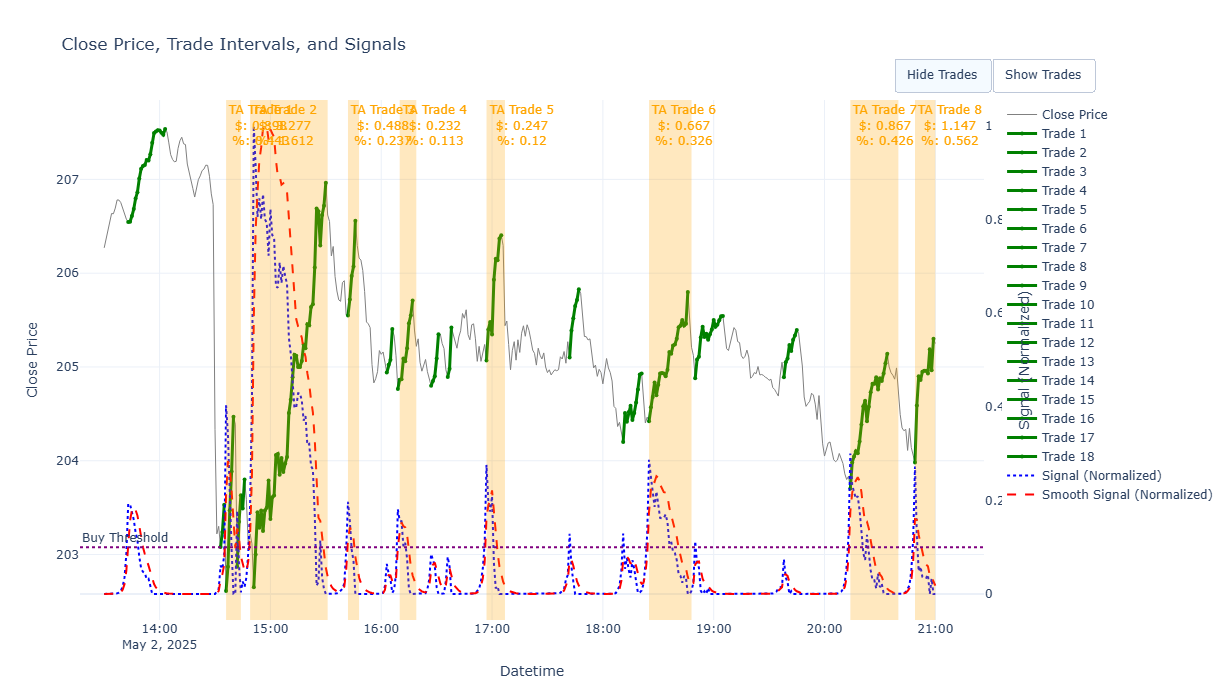

{'Final Net Value ($)': 7.874, 'Buy & Hold Gain ($)': 0.842, 'Strategy Profit Difference ($)': 7.032, 'Final Net Return (%)': 3.852, 'Buy & Hold Return (%)': 0.412, 'Strategy Improvement (%)': 3.44, 'Trade Gains ($)': [0.898, 3.277, 0.488, 0.232, 0.247, 0.667, 0.867, 1.147], 'Trade Gains (%)': [0.443, 1.612, 0.237, 0.113, 0.12, 0.326, 0.426, 0.562]}


,open,high,low,close,volume,ask,bid,open_orig,high_orig,low_orig,close_orig,volume_orig,ask_orig,bid_orig,signal,signal_smooth,signal_norm,signal_smooth_norm,trade_action,Position,Cash,NetValue,Action,TradedAmount,StrategyEarning,BuyHoldEarning,EarningDiff
2025-05-02 13:30:00,206.118,206.3697,206.066,206.2704,12094.0,206.3323,206.2085,206.30,207.00,206.250,206.7621,29343,206.8241,206.7001,0.000048,0.000048,0.000012,0.000015,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2025-05-02 13:31:00,206.292,206.5737,206.071,206.3704,21190.0,206.4323,206.3085,206.77,207.02,205.905,206.4800,53224,206.5419,206.4181,0.000094,0.000063,0.000023,0.000019,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2025-05-02 13:32:00,206.364,206.6740,206.121,206.4288,24503.0,206.4907,206.3669,206.31,206.74,206.150,206.3918,24160,206.4537,206.3299,0.000191,0.000106,0.000046,0.000032,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2025-05-02 13:33:00,206.398,206.8020,206.129,206.5368,31221.0,206.5987,206.4748,206.40,206.90,206.140,206.7500,45735,206.8120,206.6880,0.000363,0.000191,0.000088,0.000059,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
2025-05-02 13:34:00,206.476,206.9000,206.139,206.6366,34945.0,206.6985,206.5746,206.60,206.84,206.250,206.7989,22263,206.8609,206.7369,0.000686,0.000356,0.000167,0.000109,0,0,0.000,0.000,No trade,0,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-02 20:56:00,204.970,205.0900,204.910,204.9300,421586.0,204.9915,204.8685,204.97,205.09,204.910,204.9300,421586,204.9915,204.8685,0.170000,0.193411,0.041312,0.059252,0,1,-197.365,7.504,Hold,0,7.504,0.472,7.032
2025-05-02 20:57:00,204.930,205.2400,204.930,205.1899,560091.0,205.2515,205.1283,204.93,205.24,204.930,205.1899,560091,205.2515,205.1283,0.000000,0.128941,0.000000,0.039501,0,1,-197.365,7.764,Hold,0,7.764,0.732,7.032
2025-05-02 20:58:00,205.180,205.2100,204.860,204.9650,718001.0,205.0265,204.9035,205.18,205.21,204.860,204.9650,718001,205.0265,204.9035,0.135000,0.130960,0.032807,0.040120,0,1,-197.365,7.539,Hold,0,7.539,0.507,7.032
2025-05-02 20:59:00,204.950,205.5000,204.880,205.3000,1658517.0,205.3616,205.2384,204.95,205.50,204.880,205.3000,1658517,205.3616,205.2384,0.000000,0.087307,0.000000,0.026747,0,1,-197.365,7.874,Hold,0,7.874,0.842,7.032


In [8]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=ticker,
                        min_prof_thr=min_prof_thr, 
                        max_down_prop=max_down_prop, 
                        gain_tightening_factor=gain_tightening_factor,
                        smooth_win_sig=smooth_win_sig, 
                        pre_entry_decay=pre_entry_decay, 
                        buy_threshold=buy_threshold, 
                        trailing_stop_thresh=trailing_stop_thresh,
                        day_to_check=day_to_check,
                        reduce_win=reduce_win
                        )

df_fin